In [1]:
# !pip install langchain-opentutorial

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_teddynote import logging

logging.langsmith("CH15-Agentic-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agentic-RAG


# NaiveRAG + RelevanceCheck + WebSearch + QueryRewrite

** 실습 자료 **

소프트웨어정책연구소(SPRi), [AI Brief 스페셜] AI 에이전트 동향

- 저자: 유재흥(AI정책연구실 책임연구원), 이해수(AI정책연구실 선임연구원)
- 발생: 2024.12.10
- 링크: https://spri.kr/posts/view/23798?code=AI-Brief&s_year=&data_page=1
- 파일명: `SPRi AI Brief_Special_AI Agent_241209_F`

(실습 준비)
- 작업 폴더 하위에 `data` 폴더 생성 
- 링크에서 다운로드 받은 파일을 `data` 폴더에 업로드 

In [5]:
file_path = ["data/SPRi AI Brief_Special_AI Agent_241209_F.pdf"]

### Retrieval Chain

In [6]:
from langchain_opentutorial.rag.pdf import PDFRetrievalChain

In [7]:
pdf_file = PDFRetrievalChain(file_path).create_chain()

pdf_retriever = pdf_file.retriever
pdf_chain = pdf_file.chain

### State 정의

In [8]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

In [9]:
class GraphState(TypedDict):  
    question: Annotated[list, add_messages] # 질문 -> 형식 수정(누적되는 list)
    context: Annotated[str, "Context"]      # 문서의 검색 결과  
    answer: Annotated[str, "Answer"]        # 답변  
    messages: Annotated[list, add_messages] # 메시지(누적되는 list)  
    relevance: Annotated[str, "Relevance"]  # 관련성  

### Node 정의

In [10]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_opentutorial.rag.utils import format_docs

이미 정의한 노드

In [11]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # latest_question = state["question"]
    latest_question = state["question"][-1].content
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs) 
    
    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # latest_question = state["question"]
    latest_question = state["question"][-1].content
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

In [12]:
# 관련성 체크 노드  
def relevance_check(state: GraphState) -> GraphState:  
    # 관련성 평가기 생성
    question_answer_relevant = GroundednessChecker(  
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"  
    ).create()  

    # 관련성 체크를 실행("yes" or "no")  
    response = question_answer_relevant.invoke(  
        # {"question": state["question"], "context": state["context"]}  
        {"question": state["question"][-1].content, "context": state["context"]}
    )  

    # print("==== [RELEVANCE CHECK] ====")  
    # print(response.score)  
    return GraphState(relevance=response.score)  


# 관련성 체크하는 함수(router)  
def is_relevant(state: GraphState) -> GraphState:  
    return state["relevance"]  

In [13]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()
    
    # search_query = state["question"]
    search_query = state["question"][-1].content

    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",     # 일반 주제
        # days=1,
        max_results=3,       # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return GraphState(context="\n".join(search_result))

Query Rewrite 노드 (신규 정의)

In [14]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [15]:
# Query Rewrite 프롬프트 정의
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)


In [16]:
question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [17]:
# 질문 재작성
question = "앤스로픽에 투자한 미국기업"
question_rewriter.invoke({"question": question})

'앤스로픽에 투자한 미국 기업은 어떤 곳들이 있나요?'

In [18]:
# Query Rewrite 노드
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    
    return GraphState(question=question_rewritten)

### 그래프 정의

In [19]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [20]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)
workflow.add_node("query_rewrite", query_rewrite)  # Query Rewrite 노드 추가

workflow.add_edge("retrieve", "relevance_check")      # 검색 -> 관련성 체크
# workflow.add_edge("relevance_check", "llm_answer")  # 관련성 체크 -> 답변
workflow.add_edge("query_rewrite", "retrieve")        # 질문 재작성 -> 검색

workflow.add_conditional_edges(
    "relevance_check",  
    is_relevant,
    {
        "yes": "llm_answer", 
        "no": "web_search",  
    },
)

workflow.add_edge("web_search", "llm_answer")  
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("query_rewrite")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

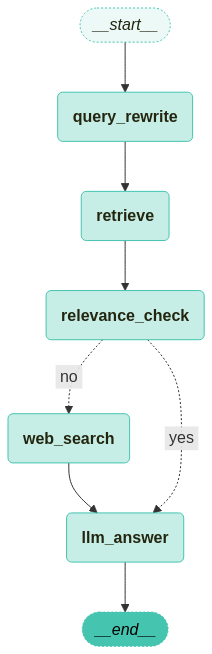

In [21]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(app)  

### 그래프 실행

In [22]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

In [23]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})
inputs = GraphState(question="Anthropic 투자 금액")

stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
아마존은 AI 스타트업 Anthropic에 총 80억 달러를 투자했습니다. 이 금액은 2023년 11월에 추가된 40억 달러를 포함합니다.

**Source**
- Amazon, Anthropic에 대한 투자를 두 배로 늘림 - AI넷 (페이지 1) 
- Anthropic, 20억 달러 자금 조달 협상 중... 기업 가치 600억 달러 도달 (페이지 1)

In [24]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: [HumanMessage(content='Anthropic 투자 금액', additional_kwargs={}, response_metadata={}, id='56f90000-19b7-471e-9ac3-bb43a285c00c'), HumanMessage(content='"Anthropic에 대한 투자 금액은 얼마인가요?"', additional_kwargs={}, response_metadata={}, id='6fcd03c5-a6b2-43a6-92af-7e252120839d')]
Answer:
아마존은 AI 스타트업 Anthropic에 총 80억 달러를 투자했습니다. 이 금액은 2023년 11월에 추가된 40억 달러를 포함합니다.

**Source**
- Amazon, Anthropic에 대한 투자를 두 배로 늘림 - AI넷 (페이지 1) 
- Anthropic, 20억 달러 자금 조달 협상 중... 기업 가치 600억 달러 도달 (페이지 1)


-----
** End of Documents **